In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import sem

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker
from venn import venn, pseudovenn
import seaborn as sns
from matplotlib.collections import PathCollection

from Bio import SeqIO, SeqUtils
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from addict import Dict
import json

import matplotlib.ticker as mticker
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Patch

In [4]:
import proteomics_functions as prot_fun

sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot

(<Figure size 72x72 with 1 Axes>, <AxesSubplot:>)

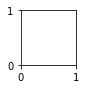

In [5]:
my_plot.instantiate_fig(1, 1)

# Load data

In [6]:
sample_columns = ['hccf_feed', 'hccf_large', 'hccf_small', 'hccf_mab', 'hccf_spf1', 'hccf_spf2', 'pavin_feed', 'pavin_large', 'pavin_small', 'pavin_mab']
sample_nice_names = ['HCCF Feed', 'HCCF Large agg.', 'HCCF Small agg.', 'HCCF mAb', 'HCCF SPF 1', 'HCCF SPF 2', 'PAVIN Feed', 'PAVIN Large agg.', 'PAVIN Small agg.', 'PAVIN mAb']

In [7]:
df_risk = pd.read_csv('./generated_tables/high_risk_swath_reviewed.csv')

df_risk.rename(columns={'impact':'Impact'}, inplace=True)
for i, cont in df_risk.iterrows():
    name = cont['name']
    df_risk.at[i, 'name'] = name[:1].upper() + name[1:-21]
df_risk.set_index('name', inplace=True)

df_risk_plot = df_risk[sample_columns]
df_risk_plot.columns = sample_nice_names

In [8]:
df_dtr = pd.read_csv('./generated_tables/difficult_to_remove_swath_reviewed.csv')

for i, cont in df_dtr.iterrows():
    name = cont['name']
    df_dtr.at[i, 'name'] = name[:1].upper() + name[1:-21]
df_dtr.set_index('name', inplace=True)

df_dtr_plot = df_dtr[sample_columns]
df_dtr_plot.columns = sample_nice_names

# High-risk

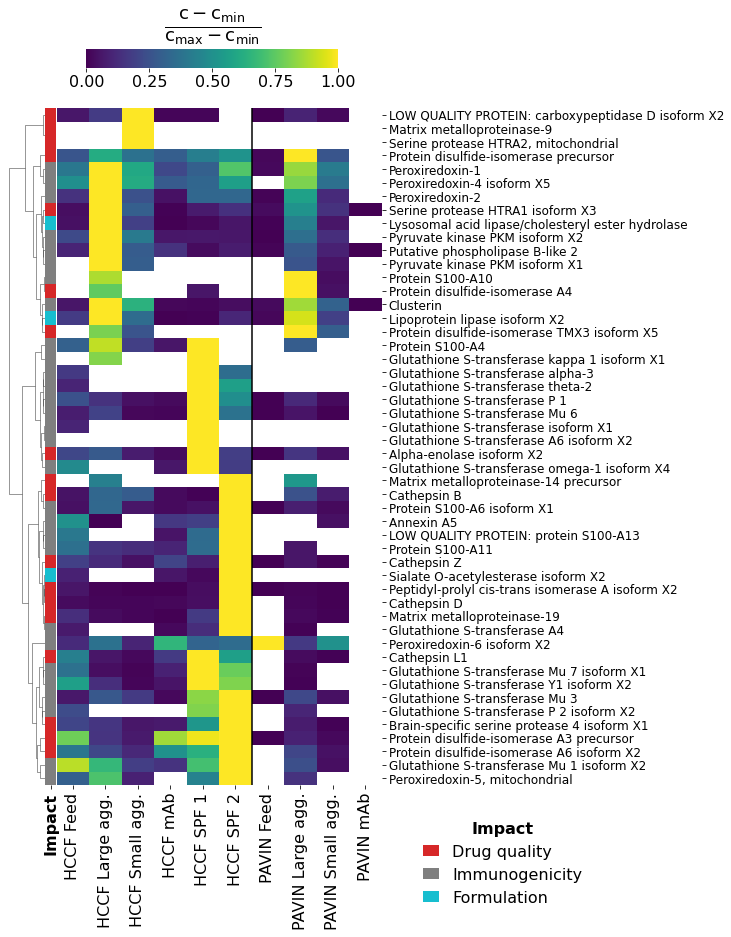

In [12]:
cmap_impact = dict(zip(df_risk.Impact.unique(), ["tab:red", "tab:grey", "tab:cyan"]))
row_colors = df_risk.Impact.map(cmap_impact)

ax = sns.clustermap(df_risk_plot, method='ward', standard_scale=0, dendrogram_ratio=(0.1, 0.05), figsize=(14, 13), yticklabels=True, col_cluster=False,
                   cbar_pos=(0.1, 0.98, 0.25, 0.02), cbar_kws={'orientation':'horizontal'}, row_colors=row_colors, mask=df_risk_plot==0.0, cmap='viridis')

fontsize = 16
rotation = 90

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

# Set colorbar
cbar_text = ax.ax_cbar.set_title(r'$\mathsf{\frac{c - c_{min}}{c_{max} - c_{min}}}$', fontsize=26, pad=15)
label_format = '{:,.2f}'
ticks_loc = ax.ax_cbar.get_xticks().tolist()
_ = ax.ax_cbar.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
_ = ax.ax_cbar.set_xticklabels([label_format.format(x) for x in ticks_loc], fontsize=fontsize)
cbar_col_labels = ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = fontsize)

# Draw a line between HCCF and PAVIN
heat = ax.ax_heatmap
r = heat.add_patch(Rectangle((6, 0), 0, len(df_risk_plot), fill=False, edgecolor='black', lw=1.5))

# Add legend
handles = [Patch(facecolor=cmap_impact[name]) for name in cmap_impact]
plt.legend(handles, cmap_impact, title='Impact', bbox_to_anchor=(0.42, 0.07), bbox_transform=plt.gcf().transFigure, loc='lower left', 
           fontsize=16, frameon=False, handlelength=1, title_fontproperties={'weight':'bold', 'size':16})

# Set row color label 
rotation = 90
ax_row_colors = ax.ax_row_colors
ax_row_colors.set_xticklabels(ax_row_colors.get_xmajorticklabels(), rotation=rotation, ha='right', rotation_mode='anchor', va='center', fontsize=16, weight='bold')

# Set heatmap tick labels
heat = ax.ax_heatmap
_ = heat.set_xticklabels(heat.get_xmajorticklabels(), rotation=rotation, ha='right', rotation_mode='anchor', va='center', fontsize=16)
_ = heat.set_yticklabels(heat.get_ymajorticklabels(), fontsize=12)

ax.savefig(f'./images/14b_high_risk_swath_clustermap_white_background.png', dpi=300, facecolor='white', transparent=False)
ax.savefig(f'./images/14b_high_risk_swath_clustermap_white_background.pdf', dpi=300)

# Difficult-to-remove

In [27]:
papers = ['Biophorum DTR', 'Biophorum high-risk', 'Levy 2014 - Association', 'Aboulaich 2014 - Association', 'Zhang 2016 - Pro A', 
          'Levy 2016 - Coelution', 'Molden 2021 - 29 DS', 'Falkenberg 2019 - 6 DS', 'Kreimer 2017 - 1 DS']

df_dtr.fillna(value=False, inplace=True)

for i, cont in df_dtr.iterrows():
    for paper in papers:
        if cont[paper]:
            df_dtr.at[i, paper] = True
        else:
            pass
        
for paper in papers:
    df_dtr[paper] = df_dtr[paper].astype(bool, copy=False)
    
for i, paper in enumerate(papers):
    if i == 0:
        row_colors = prot_fun.map_binary_colorbar(df_dtr[paper], color=f'C{i}')
    elif i == 8:
        row_colors = prot_fun.map_binary_colorbar(df_dtr[paper], color='cyan', row_colors=row_colors)
    else:
        row_colors = prot_fun.map_binary_colorbar(df_dtr[paper], color=f'C{i}', row_colors=row_colors)

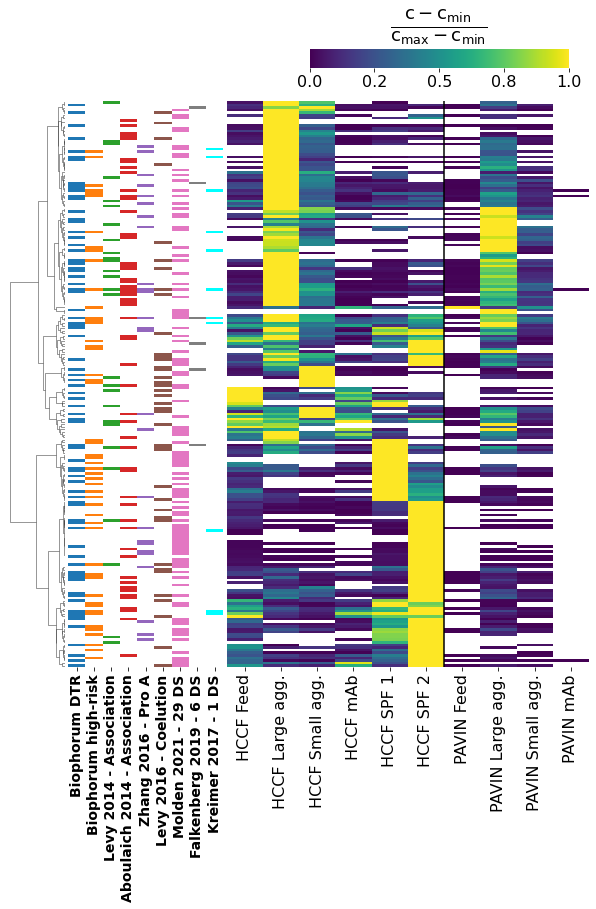

In [28]:
ax = sns.clustermap(df_dtr_plot, method='ward', standard_scale=0, dendrogram_ratio=(0.1, 0.05), figsize=(9, 13), yticklabels=False, col_cluster=False,
                   cbar_pos=(0.5, 0.98, 0.4, 0.02), cbar_kws={'orientation':'horizontal'}, row_colors=row_colors, mask=df_dtr_plot==0.0, cmap='viridis')

fontsize = 16
rotation = 90

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

# Set colorbar
cbar_text = ax.ax_cbar.set_title(r'$\mathsf{\frac{c - c_{min}}{c_{max} - c_{min}}}$', fontsize=26, pad=15)
label_format = '{:,.1f}'
ticks_loc = ax.ax_cbar.get_xticks().tolist()
_ = ax.ax_cbar.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
_ = ax.ax_cbar.set_xticklabels([label_format.format(x) for x in ticks_loc], fontsize=fontsize)
cbar_col_labels = ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = fontsize)

# Draw a line between HCCF and PAVIN
heat = ax.ax_heatmap
r = heat.add_patch(Rectangle((6, 0), 0, len(df_dtr_plot), fill=False, edgecolor='black', lw=1.5))

# Set row color label 
rotation = 90
ax_row_colors = ax.ax_row_colors
_ = ax_row_colors.set_xticklabels(ax_row_colors.get_xmajorticklabels(), rotation=rotation, ha='right', rotation_mode='anchor', va='center', fontsize=14, weight='bold')

ax.savefig(f'./images/14b_dtr_swath_clustermap_white_background.png', dpi=300, facecolor='white', transparent=False)
ax.savefig(f'./images/14b_dtr_swath_clustermap_white_background.pdf', dpi=300)